# Proyecto 1 - Inteligencia de Negocios

## Integrantes - Sección 2
- Frank Worman Garcia Eslava
- Carlos Enrique Peñuela Mejia
- Juan Pablo Baldion Castillo

Todos los participantes (Estudiante 1, 2, y 3) colaboraron en todos los proceso del desarrollo del laboratorio por igual

In [128]:
# Imports

# Data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Text processing
import re
import string
import unicodedata
from collections import Counter
import inflect
import nltk
from nltk.corpus import stopwords
from statistics import mode
nltk.download('stopwords')

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

# Profiling
import ydata_profiling

# Set stop words
stop_words = set(stopwords.words('spanish'))  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\baldi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [129]:
#Funciones

def remove_stopwords_c(text):
    words = text.split()
    meaningful_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(meaningful_words)

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            if word.lower() not in stop_words:
                new_words.append(word)
    return new_words

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            word = word.lower()
            new_words.append(word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words


def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [130]:
train_file = "fake_news_spanish.csv"

validation_file = "fake_news_validation.csv"

In [131]:
df_train = pd.read_csv(train_file, sep=";", on_bad_lines='warn', usecols=['Label', 'Titulo', 'Descripcion'])

In [132]:
print(df_train.head())

   Label                                             Titulo  \
0      1  'The Guardian' va con Sánchez: 'Europa necesit...   
1      0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3      1  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
4      0  Puigdemont: 'No sería ninguna tragedia una rep...   

                                         Descripcion  
0  El diario británico publicó este pasado jueves...  
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...  
2  El valencianismo convoca en Castelló su fiesta...  
3  En política, igual que hay que negociar con lo...  
4  En una entrevista en El Punt Avui, el líder de...  


In [133]:
# Ver ]el porcentaje de atributos vacios
# Ver el porcentaje de atributos vacios
df_porcentajes = df_train.isna().mean() * 100
print(df_porcentajes)

# Ver el número de líneas nulas
num_null_lines = df_train.isna().sum()
print(num_null_lines)

Label          0.000000
Titulo         0.028039
Descripcion    0.000000
dtype: float64
Label           0
Titulo         16
Descripcion     0
dtype: int64


In [134]:
#Delete the rows with missing values
df_train = df_train.dropna()

In [135]:
num_duplicated_lines = df_train.duplicated().sum()
print(f'Number of duplicated lines: {num_duplicated_lines}')

Number of duplicated lines: 449


In [136]:
# Describe the data
print(df_train.describe())


             Label
count  57047.00000
mean       0.58124
std        0.49336
min        0.00000
25%        0.00000
50%        1.00000
75%        1.00000
max        1.00000


In [137]:

texto = df_train.copy()

#colum descripcion
texto['Descripcion'] = texto['Descripcion'].apply(remove_stopwords_c)

texto['Conteo_descripcion'] = [len(x) for x in texto['Descripcion']]
texto['Moda_descripcion_palabra'] = [Counter(i.split(' ')).most_common(1)[0][0] for i in texto['Descripcion']]
texto['Moda_descripcion'] = [mode([len(x) for x in i.split(' ')]) for i in texto['Descripcion']]
texto['Max_descripcion'] = [max([len(x) for x in i.split(' ')]) for i in texto['Descripcion']]
texto['Min_descripcion'] = [min([len(x) for x in i.split(' ')]) for i in texto['Descripcion']]

# colum titulo

texto['Titulo'] = texto['Titulo'].apply(remove_stopwords_c)

texto['Conteo_titulo'] = [len(x) for x in texto['Titulo']]
texto['Moda_titulo_palabra'] = [Counter(i.split(' ')).most_common(1)[0][0] for i in texto['Titulo']] # para determianr la palabra mas comun
texto['Moda_titulo'] = [mode([len(x) for x in i.split(' ')]) for i in texto['Titulo']]
texto['Max_titulo'] = [max([len(x) for x in i.split(' ')]) for i in texto['Titulo']]
texto['Min_titulo'] = [min([len(x) for x in i.split(' ')]) for i in texto['Titulo']]


In [138]:
ydata_profiling.ProfileReport(texto)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Resultados Limpieza de Datos:

- Se encontraron 16 entradas en el archivo de datos sin título registrado.
- Se encontraron 449 líneas duplicadas.

Las líneas mencionadas fueron eliminadas, ya que el archivo cuenta con suficientes datos para realizar el modelo.

Los resultados del ProfileReport indicaron que el problema no está balanceado, ya que contamos con un mayor número de etiquetas para la categoría 1, que corresponde a noticias reales, en comparación con los datos etiquetados con la categoría 0.

- Categoría 1: 57.84% de los datos tienen esta etiqueta.
- Categoría 0: 42.16% de los datos tienen esta etiqueta.

### Perfilamiento de datos:

Del perfilamiento podemos notar varias tendencias en los datos:

- **Palabra más repetida:** Una palabra que es tendencia a lo largo de todos los datos es "Gobierno". Sin embargo, es más común tener nombres propios, ya sea de partidos o de políticos, en los títulos.

- Como es esperable, los títulos tienen valores de longitud mucho más pequeños que las descripciones. Sin embargo, en ambos casos contamos con valores extremos, por lo que sería recomendable ignorar esas líneas.

In [139]:
#Tokenizar 
ds_train = df_train.copy()
ds_train['palabras_descripcion'] = ds_train['Descripcion'].apply(nltk.word_tokenize)
ds_train['palabras_titulo'] = ds_train['Titulo'].apply(nltk.word_tokenize)
ds_train['palabras_descripcion'] = ds_train['palabras_descripcion'].apply(preprocessing)
ds_train['palabras_titulo'] = ds_train['palabras_titulo'].apply(preprocessing)

ds_train

Label                                             Titulo  \
0          1  'The Guardian' va con Sánchez: 'Europa necesit...   
1          0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2          1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3          1  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
4          0  Puigdemont: 'No sería ninguna tragedia una rep...   
...      ...                                                ...   
57058      1  El Defensor del Pueblo reclama a la Comunidad ...   
57059      0  El EQUO plantea ceder la presidencia de la Com...   
57060      1  Alberto Garzón: 'Que los Borbones son unos lad...   
57061      1  Vox exige entrar en el Gobierno de Castilla y ...   
57062      1  Unas 300 personas protestan contra la visita d...   

                                             Descripcion  \
0      El diario británico publicó este pasado jueves...   
1      REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2      El valencianismo convoca en Castelló su fiesta...   
3      En política, igual que hay que negociar con lo...   
4      En una entrevista en El Punt Avui, el líder de...   
...                                                  ...   
57058  El gobierno regional han indicado que la atenc...   
57059  Si la higiene democrática nos lleva a esa exig...   
57060  El coordinador federal de IU asegura que la mo...   
57061  Santiago Abascal: Vox tiene el derecho y el de...   
57062  Los Mossos dEsquadra han blindado los alrededo...   

                                    palabras_descripcion  \
0      [diario, britanico, publico, pasado, jueves, e...   
1      [revelan, gobierno, negocio, liberacion, mirel...   
2      [valencianismo, convoca, castello, fiesta, gra...   
3      [politica, igual, negociar, empresarios, negoc...   
4      [entrevista, punt, avui, lider, jxcat, desdram...   
...                                                  ...   
57058  [gobierno, regional, indicado, atencion, dia, ...   
57059  [si, higiene, democratica, lleva, exigencia, t...   
57060  [coordinador, federal, iu, asegura, monarquia,...   
57061  [santiago, abascal, vox, derecho, deber, forma...   
57062  [mossos, desquadra, blindado, alrededores, est...   

                                         palabras_titulo  
0      [the, guardian, va, sanchez, europa, necesita,...  
1      [revelan, gobierno, negocio, liberacion, mirel...  
2      [ahora, nunca, joan, fuster, estatuto, valenci...  
3      [iglesias, alienta, yolanda, diaz, erc, eh, bi...  
4      [puigdemont, seria, ninguna, tragedia, repetic...  
...                                                  ...  
57058  [defensor, pueblo, reclama, comunidad, madrid,...  
57059  [equo, plantea, ceder, presidencia, comunidad,...  
57060  [alberto, garzon, borbones, ladrones, hecho, h...  
57061  [vox, exige, entrar, gobierno, castilla, leon,...  
57062  [unas, three hundred, personas, protestan, vis...  

[57047 rows x 5 columns]

In [140]:
#Separar en train y test
ds_train, ds_test = train_test_split(ds_train, test_size=0.2, random_state=42)

In [141]:

# Join the list of characters back into strings
ds_train['Combined'] = ds_train['palabras_descripcion'] + ds_train['palabras_titulo']
ds_train['Combined'] = ds_train['Combined'].apply(lambda x: ' '.join(x))
ds_train

Label                                             Titulo  \
41712      1  El Tribunal Supremo avala que Twitter suspendi...   
15131      1  El TC paraliza parte de la Ley de Derechos His...   
9688       1  El PP recurre ante la Junta Electoral el repar...   
29762      1  Álvarez de Toledo pide que le retiren el títul...   
45301      1  Purga interna en el sindicato policial CEP tra...   
...      ...                                                ...   
54358      1  'Sal como quieras, pero no sin condones', la n...   
38170      1  El Congreso afronta su última semana de excepc...   
860        0  Un bloque de izquierdas liderado por Gabilondo...   
15803      1  Unidas Podemos fracasa en su primer intento de...   
56438      1  '¿Pero no es la misma persona?' Calvo vacila a...   

                                             Descripcion  \
41712  El alto tribunal ha coincidido con el acuerdo ...   
15131  Según fuentes del Tribunal, la providencia sus...   
9688   Entiende que no debería ser por sorteo, sino e...   
29762  La portavoz del PP acusa a Zapatero de ser un ...   
45301  La caza de brujas emprendida desde Madrid por ...   
...                                                  ...   
54358  La media de edad en España para mantener la pr...   
38170  Este martes se constituirá la Diputación Perma...   
860    La demoscopia no se pone de acuerdo en la Comu...   
15803  La confluencia entre Podemos, IU y Alianza Ver...   
56438  La vicepresidenta busca un ardid para no expli...   

                                    palabras_descripcion  \
41712  [alto, tribunal, coincidido, acuerdo, junta, e...   
15131  [segun, fuentes, tribunal, providencia, suspen...   
9688   [entiende, deberia, ser, sorteo, sino, funcion...   
29762  [portavoz, pp, acusa, zapatero, ser, mero, age...   
45301  [caza, brujas, emprendida, madrid, nueva, ejec...   
...                                                  ...   
54358  [media, edad, espana, mantener, primera, relac...   
38170  [martes, constituira, diputacion, permanente, ...   
860    [demoscopia, pone, acuerdo, comunidad, cis, pr...   
15803  [confluencia, podemos, iu, alianza, verde, com...   
56438  [vicepresidenta, busca, ardid, explicar, si, p...   

                                         palabras_titulo  \
41712  [tribunal, supremo, avala, twitter, suspendier...   
15131  [tc, paraliza, parte, ley, derechos, historico...   
9688   [pp, recurre, junta, electoral, reparto, turno...   
29762  [alvarez, toledo, pide, retiren, titulo, expre...   
45301  [purga, interna, sindicato, policial, cep, tra...   
...                                                  ...   
54358  [sal, quieras, condones, nueva, campana, sanid...   
38170  [congreso, afronta, ultima, semana, excepciona...   
860    [bloque, izquierdas, liderado, gabilondo, podr...   
15803  [unidas, podemos, fracasa, primer, intento, re...   
56438  [misma, persona, calvo, vacila, periodistas, n...   

                                                Combined  
41712  alto tribunal coincidido acuerdo junta elector...  
15131  segun fuentes tribunal providencia suspende vi...  
9688   entiende deberia ser sorteo sino funcion repre...  
29762  portavoz pp acusa zapatero ser mero agente reg...  
45301  caza brujas emprendida madrid nueva ejecutiva ...  
...                                                  ...  
54358  media edad espana mantener primera relacion se...  
38170  martes constituira diputacion permanente viene...  
860    demoscopia pone acuerdo comunidad cis pronosti...  
15803  confluencia podemos iu alianza verde comunidad...  
56438  vicepresidenta busca ardid explicar si preside...  

[45637 rows x 6 columns]

In [142]:

vectorizer = TfidfVectorizer()

X_train = ds_train['Combined']

y_train = ds_train['Label']

X_train_tfidf = vectorizer.fit_transform(X_train)

X_train_tfidf


<45637x47456 sparse matrix of type '<class 'numpy.float64'>'
	with 1314904 stored elements in Compressed Sparse Row format>

### MODELO REGRESION LOGISTICA (FRANK GARCIA)

In [143]:
#logistic regression
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_train_tfidf)


Accuracy: 0.921335758266319
Recall: 0.9812504725183337


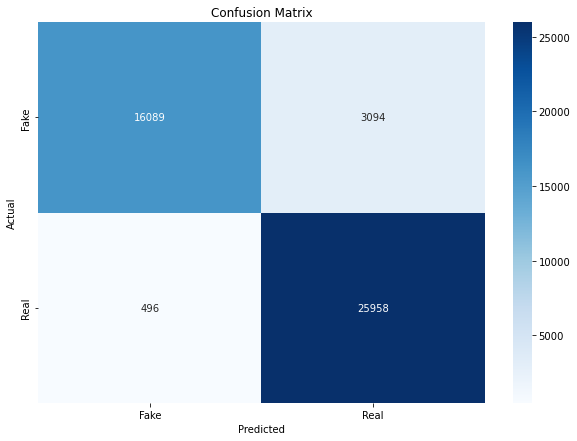

<Figure size 432x288 with 0 Axes>

In [144]:
# Evaluate the model
accuracy = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('confusion_matrix_logisticR_train.png')

In [145]:
# Test the model
ds_test['Combined'] = ds_test['Descripcion']

X_test = ds_test['Combined']
y_test = ds_test['Label']

X_test_tfidf = vectorizer.transform(X_test)

y_pred_test = model.predict(X_test_tfidf)


Accuracy: 0.7644171779141105
Recall: 0.9558472553699284


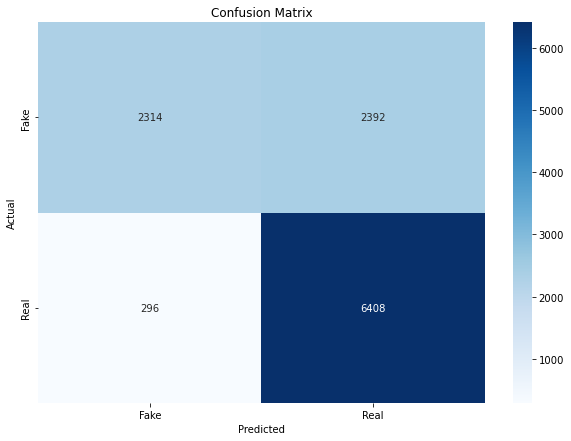

<Figure size 432x288 with 0 Axes>

In [146]:
#Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
print(f'Accuracy: {accuracy_test}')
print(f'Recall: {recall_test}')

# Generate the confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_pred_test)


# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('confusion_matrix_logisticR_test.png')


### K-MEAN (CARLOS PEÑUELA)

In [147]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_tfidf)

# Predict the clusters for the training data
train_clusters = kmeans.predict(X_train_tfidf)


Silhouette Score: 0.0022910367670162437


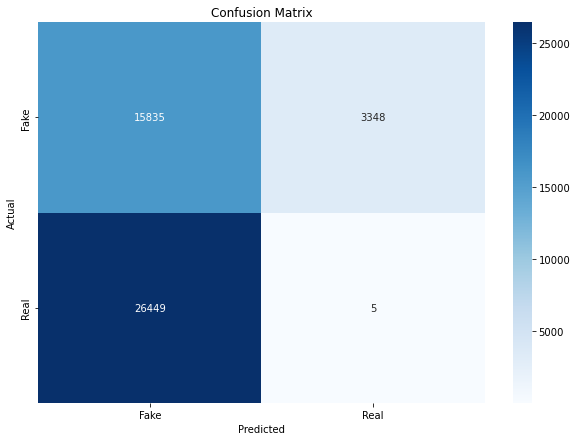

<Figure size 432x288 with 0 Axes>

In [148]:
# Evaluate the clustering results using silhouette score
silhouette_avg = silhouette_score(X_train_tfidf, train_clusters)
print(f'Silhouette Score: {silhouette_avg}')

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_train, train_clusters)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('confusion_matrix_kmeans_train.png')

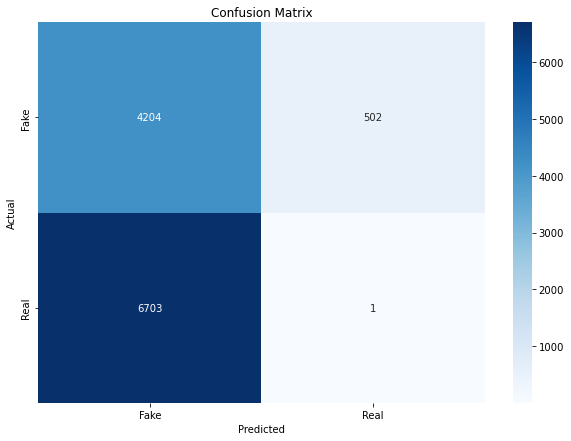

<Figure size 432x288 with 0 Axes>

In [149]:
# Predict the clusters for the test data
test_clusters = kmeans.predict(X_test_tfidf)

# Evaluate the clustering results using silhouette score
silhouette_avg = silhouette_score(X_test_tfidf, test_clusters)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, test_clusters)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('confusion_matrix_kmeans_test.png')


In [150]:
# Test the model
ds_test['Combined'] = ds_test['Descripcion']
# ds_test['Combined'] = ds_test['Combined'].apply(lambda x: ' '.join(x))

X_test = ds_test['Combined']
y_test = ds_test['Label']

X_test_tfdf = vectorizer.transform(X_test)


### MODELO NAIVE BAYES (JUAN PABLO BALDION)


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     19183
           1       0.92      0.91      0.91     26454

    accuracy                           0.90     45637
   macro avg       0.90      0.90      0.90     45637
weighted avg       0.90      0.90      0.90     45637



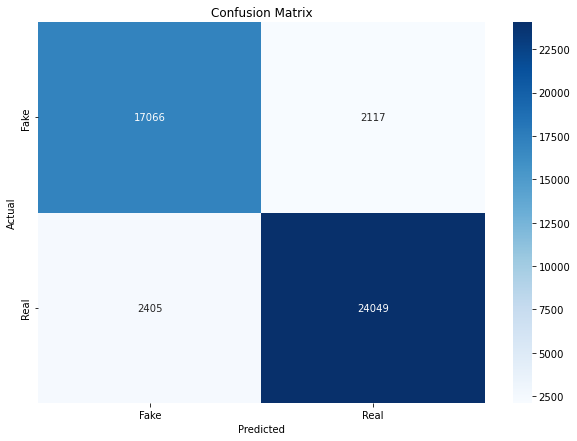

<Figure size 432x288 with 0 Axes>

In [151]:
model = MultinomialNB(class_prior=[0.5, 0.5], alpha=0.1)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_train_tfidf)
y_train = ds_train['Label']
# Evaluate the model
conf_matrix = confusion_matrix(y_train, y_pred)

print("\nReporte de clasificación:")
print(classification_report(y_train, y_pred))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('confusion_matrix_NB_train.png')


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      4706
           1       0.68      0.66      0.67      6704

    accuracy                           0.62     11410
   macro avg       0.61      0.61      0.61     11410
weighted avg       0.62      0.62      0.62     11410



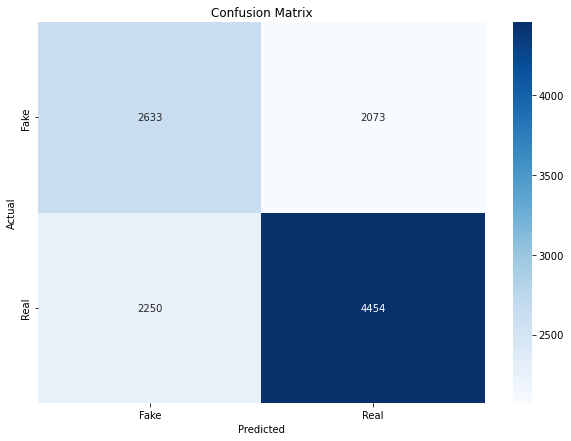

<Figure size 432x288 with 0 Axes>

In [152]:
y_pred_test = model.predict(X_test_tfdf)

# Evaluate the model
y_test = ds_test['Label']
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_test))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('confusion_matrix_NB_test.png')

### Análisis de resultados

Se evaluaron tres enfoques de aprendizaje automático para la detección de noticias falsas: Regresión Logística, K-Means y Naïve Bayes. Cada uno de estos modelos presenta características y limitaciones que influyeron en su desempeño.

Regresión Logística: se destacó como el modelo más eficiente para la tarea, con una precisión del 92% y un recall del 8% en la fase de prueba. Su buen desempeño se debe a su capacidad para modelar relaciones lineales entre las características extraídas de los textos y la etiqueta de clasificación. Sin embargo, la reducción en su precisión en comparación con el conjunto de entrenamiento (76%) sugiere la presencia de sobreajuste, lo que indica que el modelo ajustó demasiado bien a los datos de entrenamiento y perdió generalización sobre datos nuevos. A pesar de esto, el alto valor de recall lo convierte en una opción óptima para la detección de noticias falsas, ya que minimiza los falsos negativos y permite identificar la mayoría de las noticias falsas, contribuyendo a la misión de la organización de combatir la desinformación.

Naïve Bayes: mostró un desempeño intermedio, con una precisión de 90% y un F1-score de 90% en la fase de prueba. Si bien este modelo probabilístico es eficaz en escenarios donde la independencia entre características es una suposición razonable. Además, la presencia de ambigüedades y términos con múltiples significados puede afectar la calidad de las predicciones. No obstante, su rápido tiempo de entrenamiento y su relativa robustez lo convierten en una opción viable cuando se requieren soluciones computacionalmente eficientes.

K-Means: al ser un modelo de aprendizaje no supervisado, no logró un desempeño satisfactorio para la tarea de clasificación de noticias falsas. Con una precisión de apenas 34% y un recall de 0.018% en la fase de prueba, sus resultados indican que los datos no forman grupos bien diferenciados en el espacio vectorial utilizado para el clustering. Esto es esperable, ya que el análisis de texto en entornos no supervisados suele requerir técnicas avanzadas de reducción de dimensionalidad o embeddings semánticos que preserven mejor la estructura de los datos. Dado su bajo rendimiento, este modelo no resulta adecuado para la detección de noticias falsas en el contexto del proyecto.

A partir de los resultados obtenidos, se concluye que la regresión logística es el modelo más adecuado para la tarea de clasificación de noticias falsas debido a su alto recall y precisión, lo que garantiza la detección efectiva de contenido potencialmente engañoso. Esto permite a la organización implementar estrategias de mitigación de desinformación con una base sólida en modelos analíticos.



### Identificación de palabras clave en noticias falsas
Para comprender mejor los patrones lingüísticos que caracterizan las noticias falsas, se realizó un análisis de frecuencia de términos en los textos clasificados como falsos. Algunas de las palabras más recurrentes incluyen:

a. Palabras sensacionalistas: "urgente", "exclusivo", "impactante", "revelador", "descubierto".
b. Términos que apelan a la emocionalidad y el miedo: "alarmante", "peligro", "conspiración", "crisis", "amenaza".

2. Justificación de la importancia de este análisis para la organización
Este análisis es fundamental para la organización por las siguientes razones:

Optimización del modelo de detección de noticias falsas:

a. La identificación de términos característicos permite mejorar la selección de características utilizadas en los modelos de aprendizaje automático.

b. Desarrollo de estrategias preventivas contra la desinformación:

c. Conociendo los patrones lingüísticos de las noticias falsas, la organización puede desarrollar filtros automáticos para identificar contenido sospechoso en tiempo real.
Se pueden implementar alertas tempranas para advertir a los lectores cuando un artículo contenga una alta densidad de términos sospechosos.
